# Twitter Sentimental Analysis

In [15]:
# Importing the dependecies

import tweepy                             # API for getting twitter info
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os                                 # To get the api keys stored as environment variables
from textblob import TextBlob             # To analyse the sentiment
from wordcloud import WordCloud,STOPWORDS # To make a wordcloud
from dotenv import load_dotenv            # For loading the environment variables
import datetime
import time
import plotly.express as px

In [2]:
load_dotenv()

True

In [3]:
# Storing the API KEYS provided by Twitter Dev Account

api_key             = os.getenv('api_key')
api_secret_key      = os.getenv('api_secret_key')
access_token        = os.getenv('access_token')
access_token_secret = os.getenv('access_token_secret')

In [4]:
# Authorizing the API

auth = tweepy.OAuthHandler(api_key,api_secret_key)
auth.set_access_token(access_token,access_token_secret)
api = tweepy.API(auth)

In [5]:
def cleaned_tweet(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "",txt).split())

In [6]:
def calculate_polarity(tweet):
    blob = TextBlob(tweet)
    return blob.sentiment.polarity

In [7]:
tweets = []
created_at = []

def get_tweets(searchword,formatted_date,num_of_tweets):
    for tweet in tweepy.Cursor(api.search_tweets,q=searchword,tweet_mode='extended',lang='en',result_type='recent',until=formatted_date).items(num_of_tweets):
        tweets.append(tweet.full_text)
        created_at.append(tweet.created_at)

In [9]:
def get_user_inputs():
    
    global tweets
    global created_at
    tweets = []
    created_at = []

    hashtag = input("Search a keyword :")
    searchword = hashtag+'-filter:retweets AND -filter:replies'
    
    num_of_tweets = int(input("Enter number of tweets that must be scraped per day :"))    
    
    today = datetime.date.today()
    until = int(input("Enter number of days until the tweets must be scraped :"))
    
    for i in range(until,0,-1):
        delta = datetime.timedelta(days = until-2)
        until_date = today - delta
        formatted_date = until_date.strftime("%Y-%m-%d")
        until = until - 1
        get_tweets(searchword,formatted_date,num_of_tweets)
    
get_user_inputs()

Search a keyword :Bitcoin
Enter number of tweets that must be scraped per day :100
Enter number of days until the tweets must be scraped :10


In [10]:
data = {"Tweet":tweets,
        "Date":created_at}
dummy = pd.DataFrame(data)

df = dummy.copy()
df['Tweet'] = df['Tweet'].apply(lambda x:cleaned_tweet(x))
df['Polarity'] = df['Tweet'].apply(lambda x:calculate_polarity(x))
df.drop_duplicates(inplace=True)

In [11]:
df.loc[df['Polarity'] > 0, "Sentiment"] = "Positive"
df.loc[df['Polarity'] == 0, "Sentiment"] = "Neutral"
df.loc[df['Polarity'] < 0, "Sentiment"] = "Negative"

In [12]:
df

,Tweet,Date,Polarity,Sentiment
0,BTC price 61330 44569 1631 Naks per USD2244 Na...,2021-10-23 23:59:55+00:00,0.000000,Neutral
1,Free Bitcoin cloud mining Payments 100 Verifie...,2021-10-23 23:59:47+00:00,0.400000,Positive
2,Current Bitcoin transaction fees BCH Next Bloc...,2021-10-23 23:59:46+00:00,0.000000,Neutral
3,Bitcoin 1 Day social activityGalaxy Score 73 o...,2021-10-23 23:59:38+00:00,0.033333,Positive
4,Bitcoin price index USD EUR CNY GBP RUB,2021-10-23 23:59:36+00:00,0.000000,Neutral
...,...,...,...,...
995,xHashTag Solana Airdrop Get 4 1Ref in XTAG 250...,2021-11-01 05:49:13+00:00,-0.122222,Negative
996,LRC pumped 42748 1d current price is 08031 Wel...,2021-11-01 05:49:09+00:00,0.400000,Positive
997,Why am I bullish There are many reasons but at...,2021-11-01 05:49:01+00:00,0.150000,Positive
998,TurtleCoin V2 AirdropFollow Twitter Page turtl...,2021-11-01 05:48:58+00:00,0.000000,Neutral


In [13]:
pos = df[df['Sentiment']=='Positive']
neg = df[df['Sentiment']=='Negative']

### Pie chart for Positive and Negative Tweets

In [32]:
labels = ['Positive','Negative']
values = [pos.shape[0],neg.shape[0]]
px.pie(values=values,names=labels,title="Positive and Negative Tweet Pie Chart",color_discrete_sequence=['#61ff69','#ff6961'])

In [29]:
df_day = df.groupby([pd.Grouper(key='Date', freq='D'), 'Sentiment']).size().unstack('Sentiment')
df_day.index = df_day.index.strftime('%Y-%m-%d')
df_day.drop(columns='Neutral',inplace=True)
df_day

Sentiment,Negative,Positive
Date,,
2021-10-23,7,34
2021-10-24,20,34
2021-10-25,15,35
2021-10-26,7,43
2021-10-27,13,43
2021-10-28,20,34
2021-10-29,7,47
2021-10-30,13,33
2021-10-31,15,40


### Positive and Negative Tweets over the Days

In [37]:
px.line(df_day,color_discrete_sequence=['#ff6961','#61ff69'],title="Day wise Tweets",markers=True,labels={'value':'Tweets'})

In [38]:
twitter_mask = plt.imread("./twitter_mask.jpg")

### WordCloud


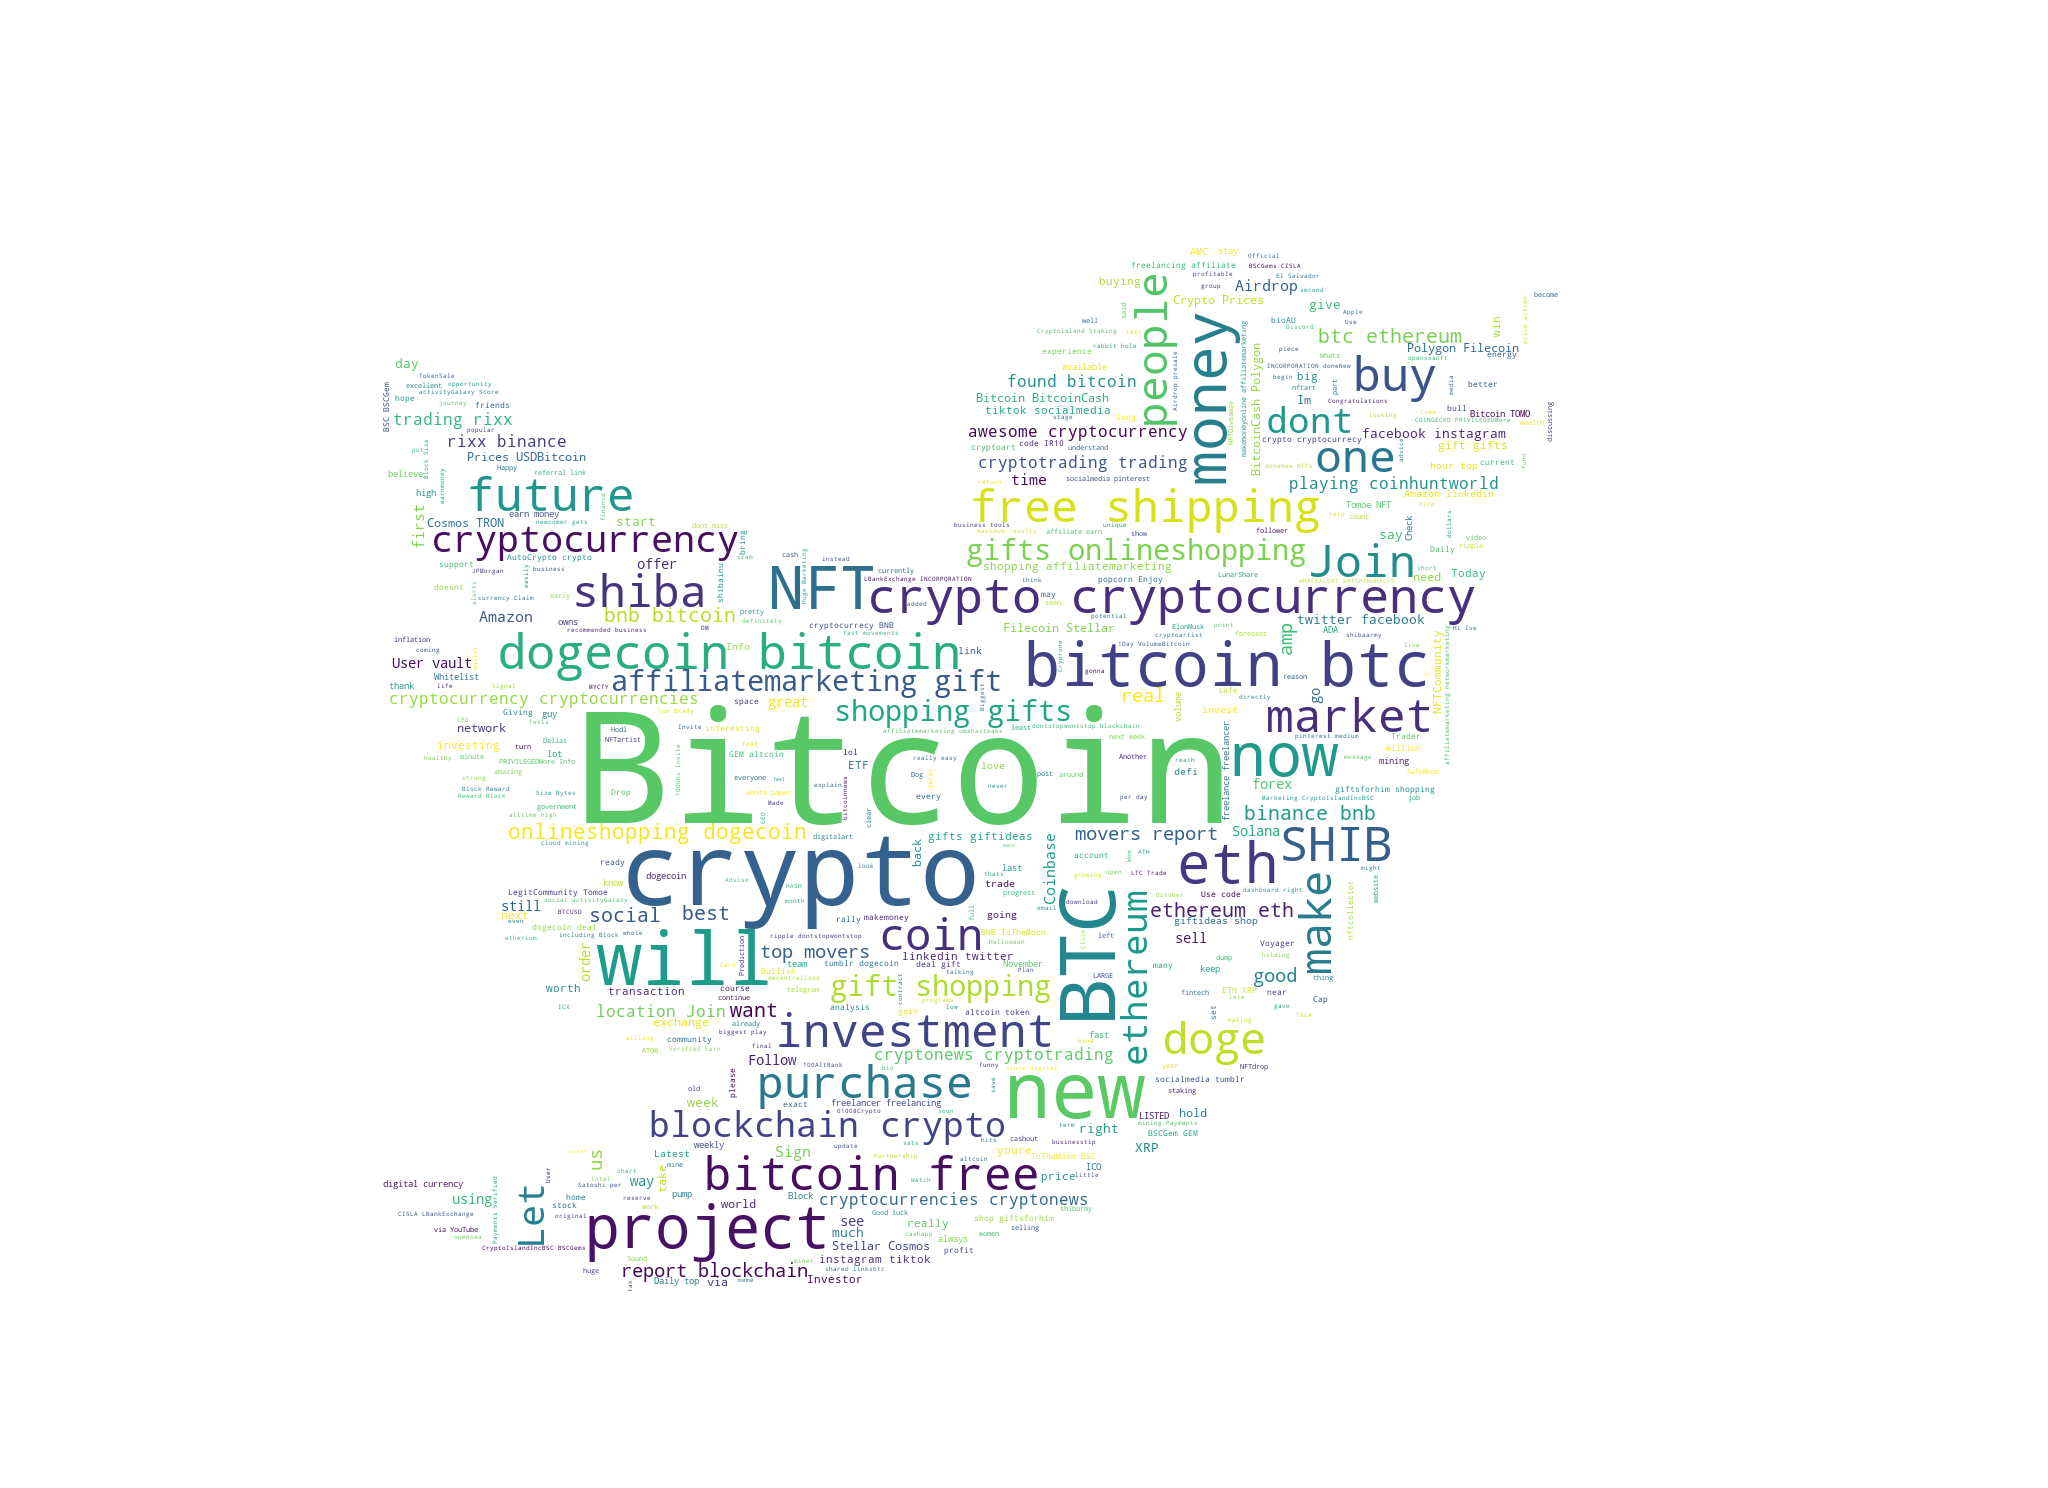

In [57]:
text = " ".join(tweet for tweet in pos['Tweet'])
wc = WordCloud(background_color="white", max_words=500, mask=twitter_mask, stopwords=STOPWORDS)
wc.generate(text)
fig = px.imshow(wc,title="WordCloud for Positive Tweets",width=980,height=900)
fig.update_layout(coloraxis_showscale=False)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()


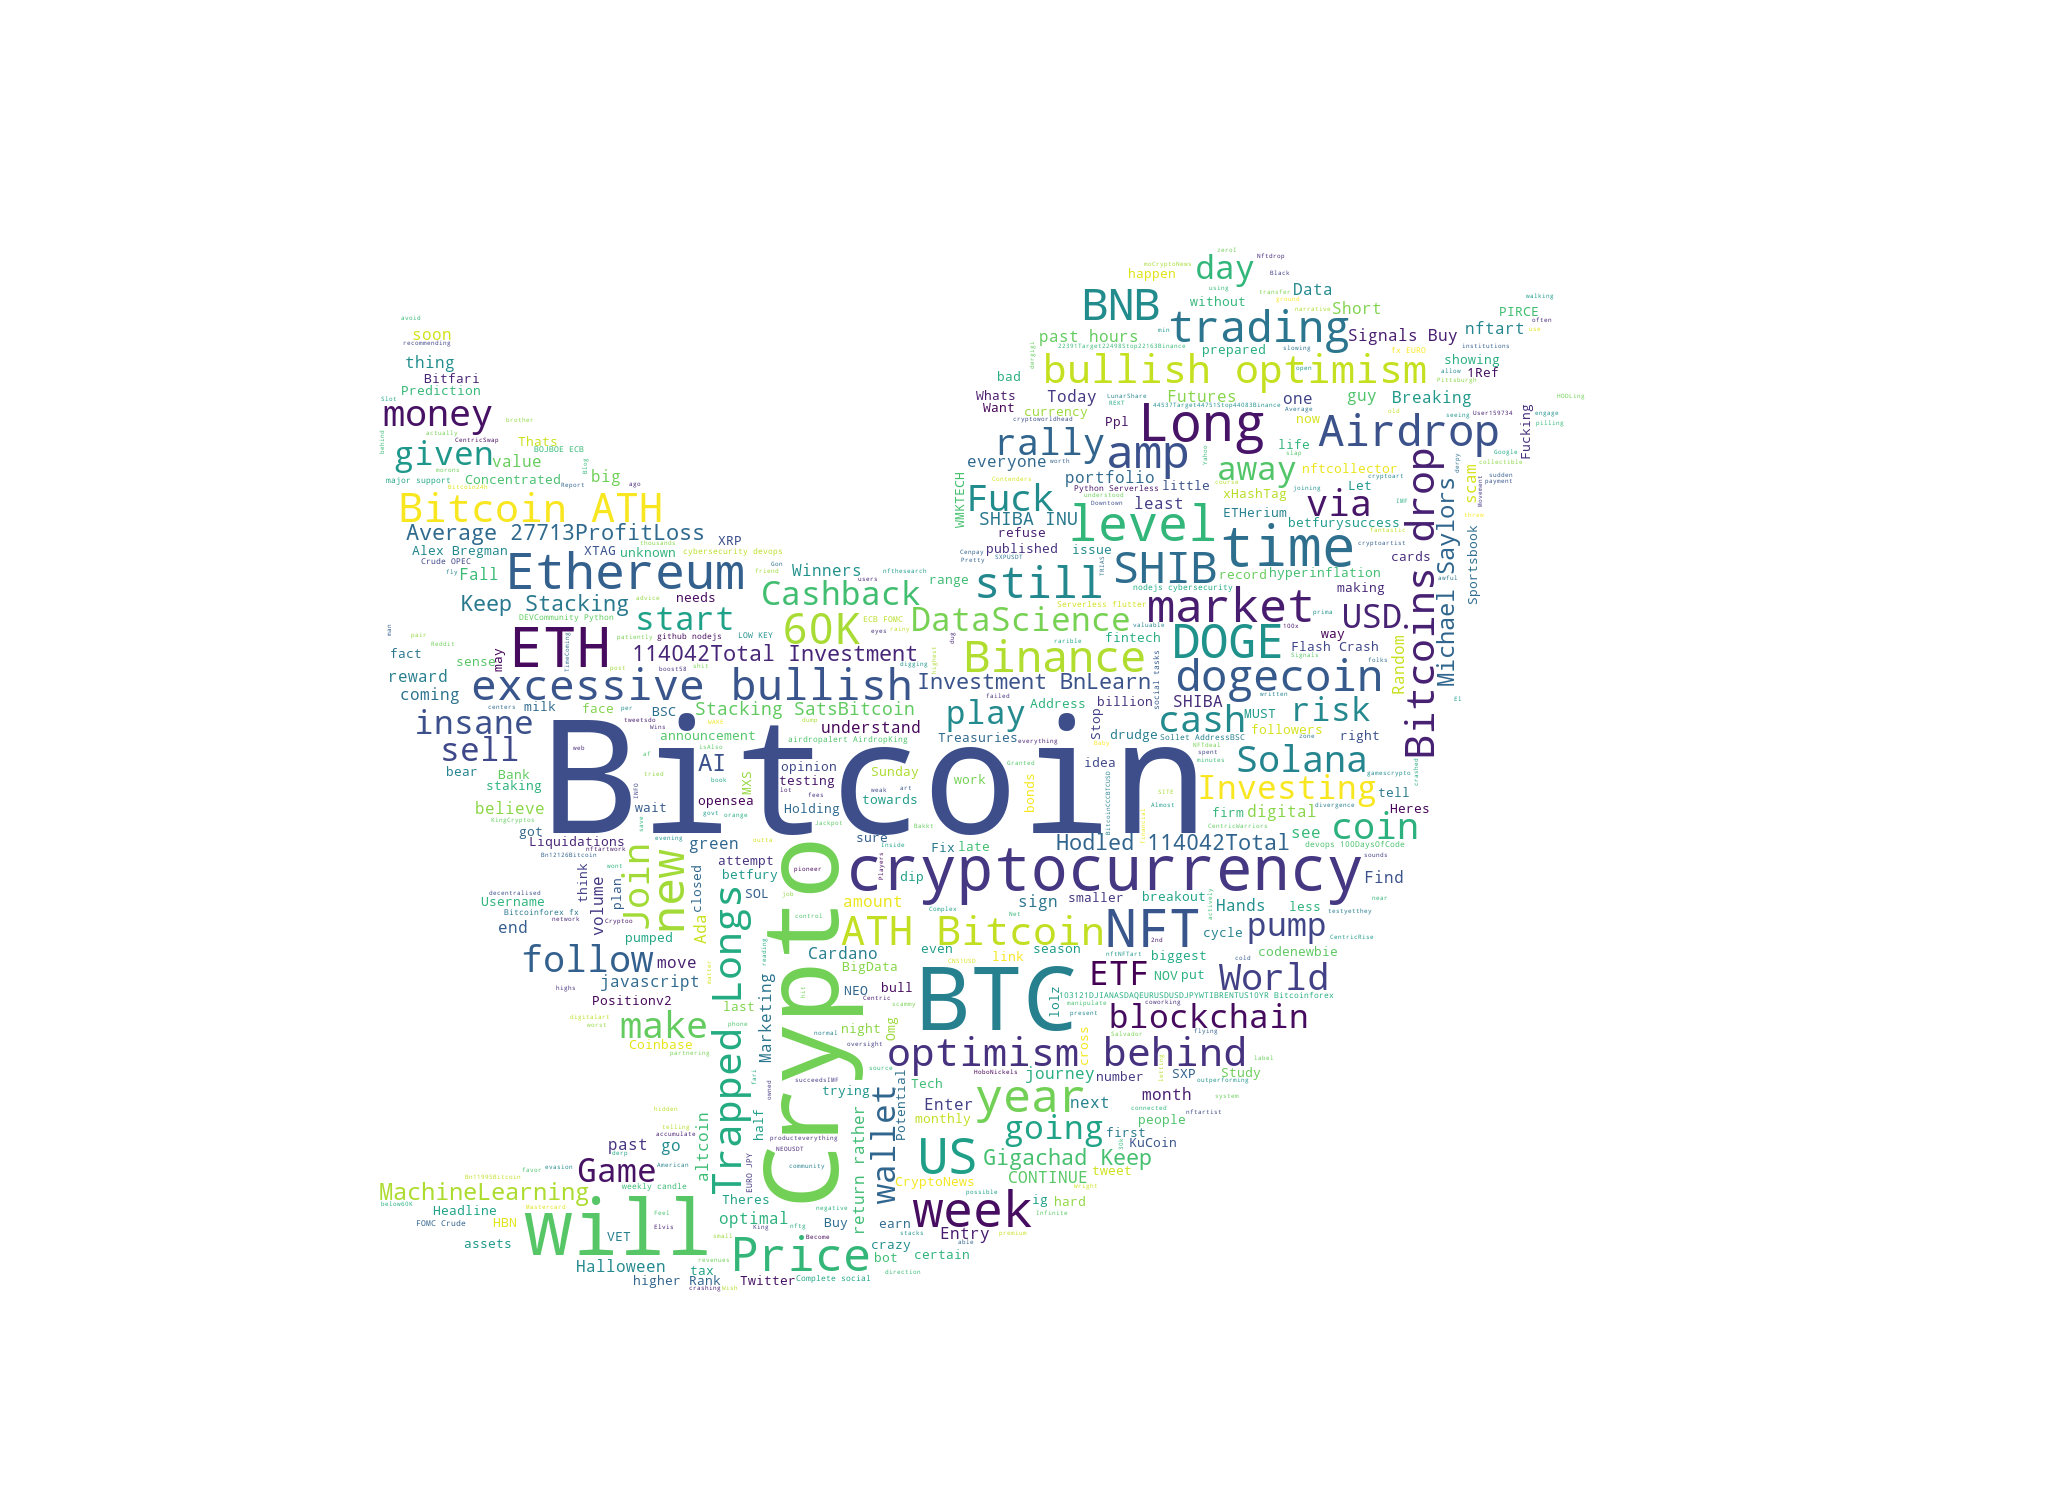

In [58]:
text = " ".join(tweet for tweet in neg['Tweet'])
wc = WordCloud(background_color="white", max_words=500, mask=twitter_mask, stopwords=STOPWORDS)
wc.generate(text)
fig = px.imshow(wc,title="WordCloud for Negative Tweets",width=980,height=900)
fig.update_layout(coloraxis_showscale=False)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()